In [1]:
import os
import json
import random
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A

In [2]:
from src.display import plot_boxes, plot_img_seg, plot_image, plot_boxes_instance_masks

In [3]:
PATH = "data/VOCdevkit/VOC2012"

In [4]:
class PascalDataset(Dataset):
    def __init__(self, data, size=320):
        self.image_path = "data/VOCdevkit/VOC2012/JPEGImages"
        self.seg_path = "data/VOCdevkit/VOC2012/SegmentationObject"
        self.data = data
        
        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
        
        self.crop = A.Compose([
            A.RandomCrop(width=size, height=size, p=1)
        ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_idxs", "names", "seg_ids"]))

    def __len__(self):
        return len(self.data)
    
    def crop_img(self, img, seg_img, bboxes, class_idxs, names, seg_ids):
        t = self.crop(image=img,
                      mask=seg_img,
                      bboxes=bboxes.tolist(),
                      class_idxs=class_idxs.tolist(),
                      names=names,
                      seg_ids=seg_ids.tolist()
                    )
        
        img = t["image"]
        seg_img = t["mask"]
        bboxes = np.array(t["bboxes"], dtype=int)
        class_idxs = np.array(t["class_idxs"])
        names = t["names"]
        seg_ids = np.array(t["seg_ids"])

        return img, seg_img, bboxes, class_idxs, names, seg_ids

    def get_plotting_item(self, idx):
        d = self.data[idx]

        img = cv2.imread(os.path.join(self.image_path, d["file_name"]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.uint8)
        seg_img = cv2.imread(os.path.join(self.seg_path, d["seg_file_name"]), cv2.IMREAD_GRAYSCALE)
        
        seg_img = np.repeat(seg_img[:, :, np.newaxis], 3, axis=2)

        bboxes = np.array([a["bbox"] for a in d["annotations"]])
        class_idxs = np.array([a["class_idx"] for a in d["annotations"]])
        names = [a["class_name"] for a in d["annotations"]]
        
        seg_ids = np.array([a["seg_mask_id"] for a in d["annotations"]], dtype=np.uint8)

        return img, seg_img, bboxes, class_idxs, names, seg_ids
    
    def __getitem__(self, idx):
        img, seg_img, bboxes, class_idxs, names, seg_ids = self.get_plotting_item(idx)
        
        img, seg_img, bboxes, class_idxs, names, seg_ids = self.crop_img(img,
                                                                         seg_img,
                                                                         bboxes,
                                                                         class_idxs,
                                                                         names,
                                                                         seg_ids)

        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).unsqueeze(0)

        seg_img = torch.from_numpy(seg_img).float().unsqueeze(0)       

        bboxes = torch.from_numpy(bboxes).float().unsqueeze(0)
        class_idxs = torch.from_numpy(class_idxs).float().unsqueeze(0)
        seg_ids = torch.from_numpy(seg_ids).unsqueeze(0)

        return img, seg_img, bboxes, class_idxs, seg_ids

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    imgs = [b[0] for b in batch]
    imgs = torch.stack(imgs, dim=0)

    seg_imgs = [b[1] for b in batch]
    seg_imgs = torch.stack(seg_imgs, dim=0)

    bboxes = [bboxes[2] for b in batch]
    class_idxs = [b[3] for b in batch]
    seg_ids = [b[4] for b in batch]

    return (imgs, seg_imgs, bboxes, class_idxs, seg_ids)

In [5]:
seed = 42
train_perc = 0.8

batch_size = 128

In [6]:
with open("data/annotations.json", "r") as fp:
    data = json.load(fp)

random.seed(seed)
random.shuffle(data)
split_idx = int(len(data) * train_perc)

train_data = data[0:split_idx]
val_data = data[split_idx:]

In [7]:
train_ds = PascalDataset(train_data)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_ds = PascalDataset(val_data)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [8]:
train_ds[0]

(tensor([[[[-0.9705, -0.9363, -0.9192,  ..., -1.0219, -1.0219, -1.0390],
           [-0.9705, -0.9363, -0.9192,  ..., -1.0219, -1.0219, -1.0390],
           [-0.9705, -0.9363, -0.9192,  ..., -1.0219, -1.0219, -1.0219],
           ...,
           [-0.6109, -1.2617, -0.6281,  ..., -0.7822, -0.7479, -0.9877],
           [-0.7822, -0.6281, -1.1932,  ..., -0.7993, -1.2617, -1.2617],
           [-1.3644, -0.3541, -0.9363,  ..., -0.1828, -0.0458, -0.9705]],
 
          [[ 0.1352,  0.1352,  0.1527,  ...,  0.1176,  0.1176,  0.1001],
           [ 0.1352,  0.1352,  0.1527,  ...,  0.1176,  0.1176,  0.1001],
           [ 0.1352,  0.1352,  0.1527,  ...,  0.1176,  0.1176,  0.1176],
           ...,
           [ 0.0126, -0.6527, -0.0049,  ..., -0.8102, -0.7927, -0.9853],
           [-0.1275,  0.0651, -0.4601,  ..., -0.6001, -1.1078, -1.1779],
           [-0.6352,  0.4503, -0.0574,  ...,  0.0476,  0.1352, -0.8803]],
 
          [[ 1.5245,  1.5245,  1.5420,  ...,  1.5594,  1.5594,  1.5420],
           [ 

In [9]:
train_ds.data[0]

{'file_name': '2011_000551.jpg',
 'seg_file_name': '2011_000551.png',
 'id': '2011_000551',
 'height': '375',
 'width': '500',
 'annotations': [{'class_name': 'bus',
   'class_idx': 6,
   'bbox': [74, 176, 202, 212],
   'seg_mask_id': 38},
  {'class_name': 'bus',
   'class_idx': 6,
   'bbox': [197, 147, 426, 234],
   'seg_mask_id': 75}]}

In [10]:
img, seg_img, bboxes, class_idxs, names, seg_ids = train_ds.get_plotting_item(1)

In [11]:
img, seg_img, bboxes, class_idxs, names, seg_ids = train_ds.crop_img(img, seg_img, bboxes, class_idxs, names, seg_ids)

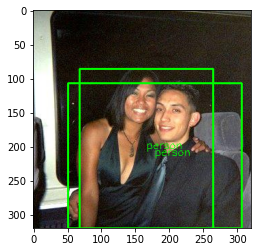

In [12]:
plot_img = plot_boxes(img, bboxes, names)
plot_image(plot_img)

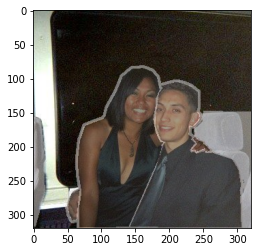

In [13]:
plot_img = plot_img_seg(img, seg_img, (seg_img > 0).astype(np.uint8))
plot_image(plot_img)

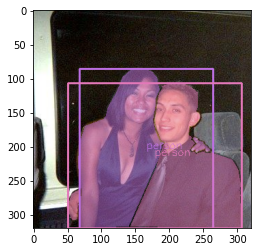

In [14]:
plot_img = plot_boxes_instance_masks(img, seg_img, bboxes, names, seg_ids)
plot_image(plot_img)